# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [5]:
df = pd.read_csv('/content/sample_data/bikes_rent.csv')

In [66]:
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

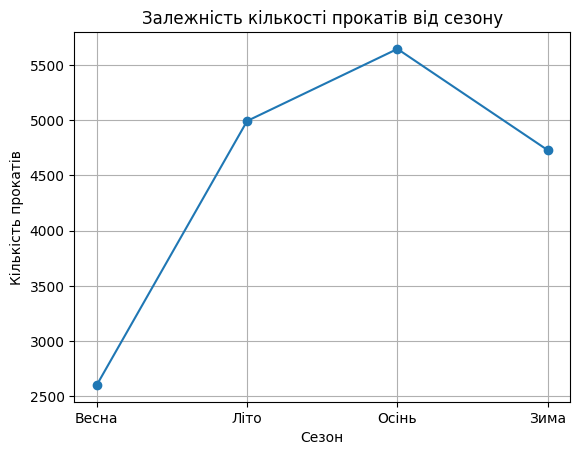

In [7]:
# График 1: season vs cnt

season_rentals = df.groupby('season')['cnt'].mean()
season_labels = ['Весна', 'Літо', 'Осінь', 'Зима']

plt.plot(season_labels, season_rentals, marker='o')
plt.xlabel('Сезон')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від сезону')
plt.grid()
plt.show()

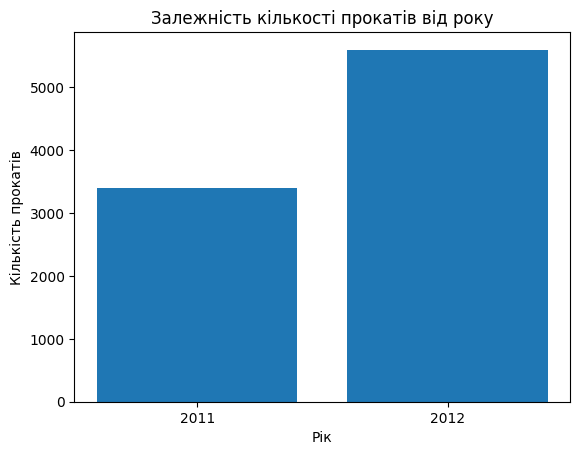

In [8]:
# График 2: yr vs cnt

year_rentals = df.groupby('yr')['cnt'].mean()
year_labels = ['2011', '2012']

plt.bar(year_labels, year_rentals)
plt.xlabel('Рік')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від року')
plt.show()

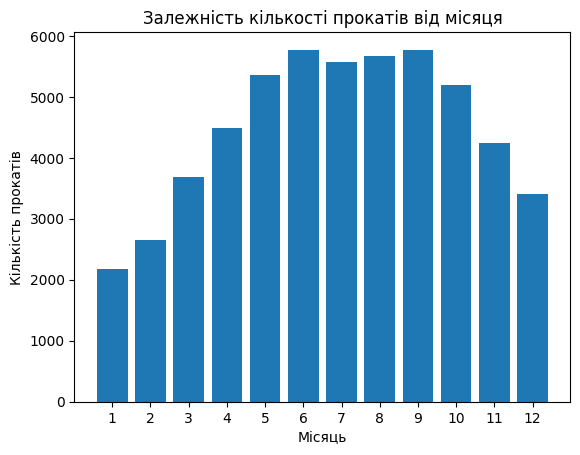

In [9]:
# График 3: mnth vs cnt

monthly_rentals = df.groupby('mnth')['cnt'].mean()

plt.bar(monthly_rentals.index, monthly_rentals.values)
plt.xlabel('Місяць')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від місяця')
plt.xticks(range(1, 13))
plt.show()

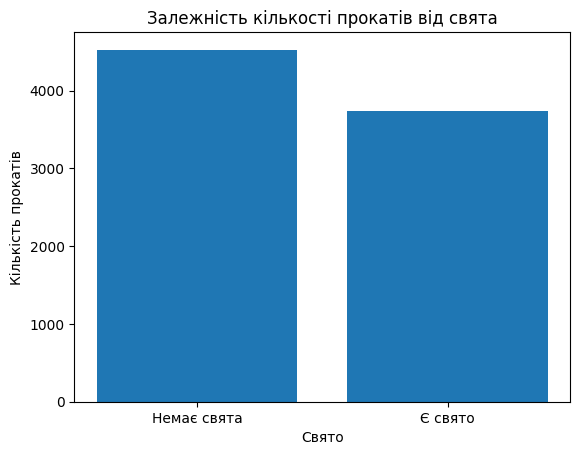

In [10]:
# График 4: holiday vs cnt

holiday_rentals = df.groupby('holiday')['cnt'].mean()
holiday_labels = ['Немає свята', 'Є свято']

plt.bar(holiday_labels, holiday_rentals)
plt.xlabel('Свято')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від свята')
plt.show()

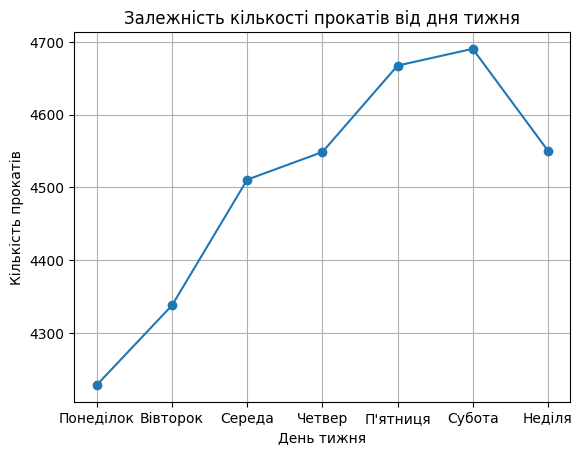

In [11]:
# График 5: weekday vs cnt

weekday_rentals = df.groupby('weekday')['cnt'].mean()
weekday_labels = ['Понеділок', 'Вівторок', 'Середа', 'Четвер', 'П\'ятниця', 'Субота', 'Неділя']

plt.plot(weekday_labels, weekday_rentals, marker='o')
plt.xlabel('День тижня')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від дня тижня')
plt.grid()
plt.show()

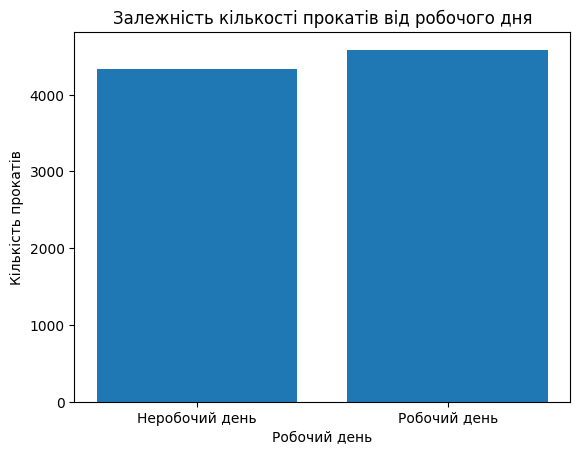

In [12]:
# График 6: workingday vs cnt

workingday_rentals = df.groupby('workingday')['cnt'].mean()
workingday_labels = ['Неробочий день', 'Робочий день']

plt.bar(workingday_labels, workingday_rentals)
plt.xlabel('Робочий день')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від робочого дня')
plt.show()

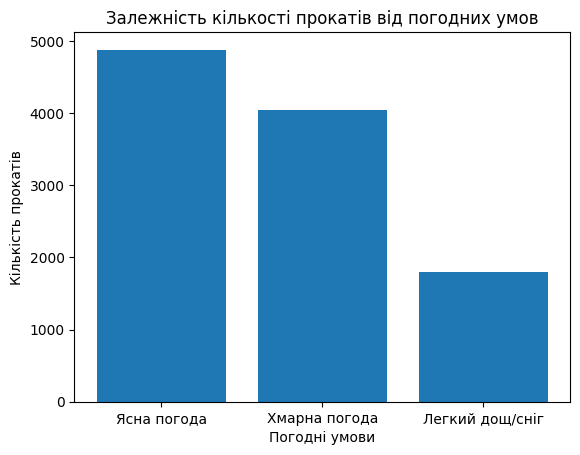

In [13]:
# График 7: weathersit vs cnt

weathersit_rentals = df.groupby('weathersit')['cnt'].mean()

weathersit_labels = ['Ясна погода', 'Хмарна погода', 'Легкий дощ/сніг']

plt.bar(weathersit_rentals.index, weathersit_rentals)
plt.xticks(weathersit_rentals.index, weathersit_labels)
plt.xlabel('Погодні умови')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від погодних умов')
plt.show()

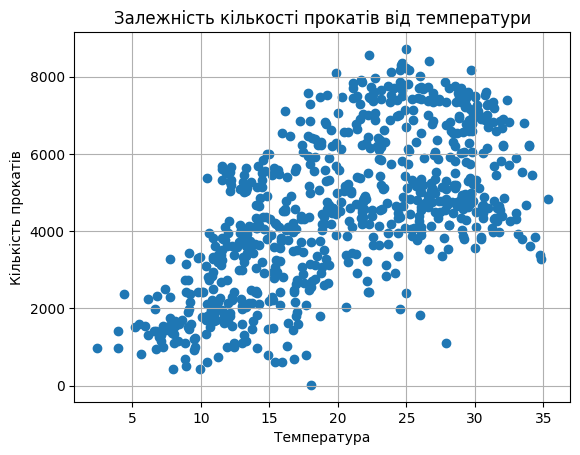

In [14]:
# График 8: temp vs cnt

plt.scatter(df['temp'], df['cnt'])

plt.xlabel('Температура')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від температури')
plt.grid()
plt.show()

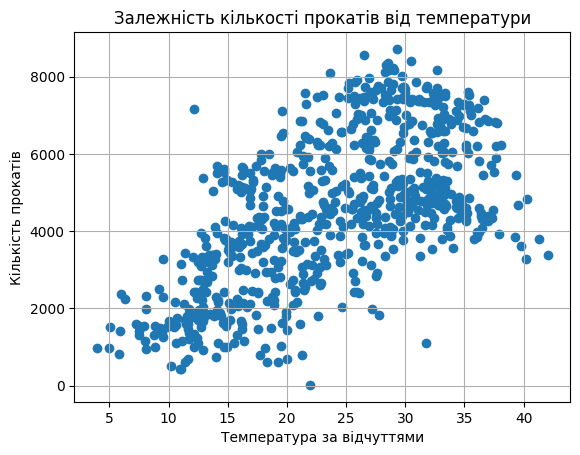

In [15]:
# График 9: atemp vs cnt
plt.scatter(df['atemp'], df['cnt'])

plt.xlabel('Температура за відчуттями')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від температури')
plt.grid()
plt.show()

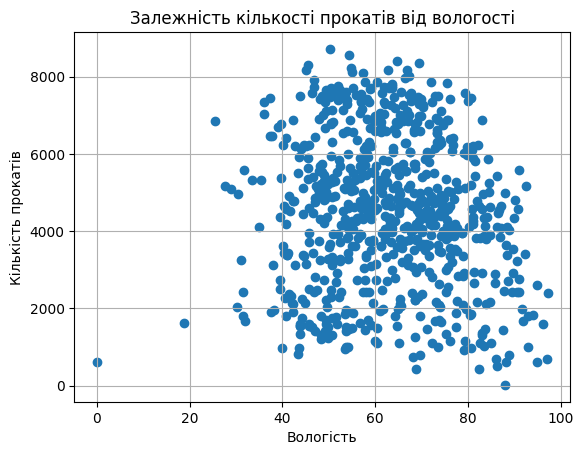

In [16]:
# График 10: hum vs cnt

plt.scatter(df['hum'], df['cnt'])

plt.xlabel('Вологість')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від вологості')
plt.grid()
plt.show()

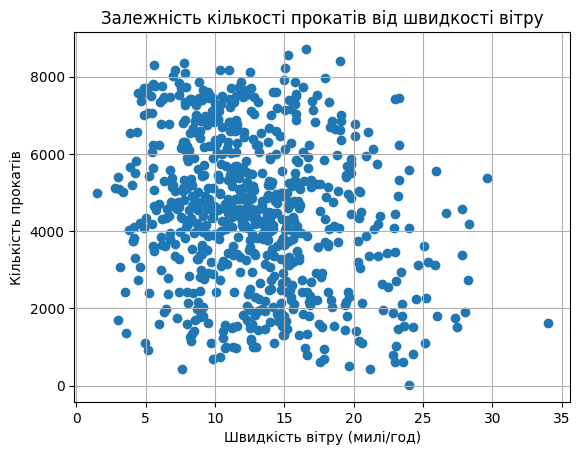

In [17]:
# График 11: windspeed(mph) vs cnt
plt.scatter(df['windspeed(mph)'], df['cnt'])

plt.xlabel('Швидкість вітру (милі/год)')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від швидкості вітру')
plt.grid()
plt.show()

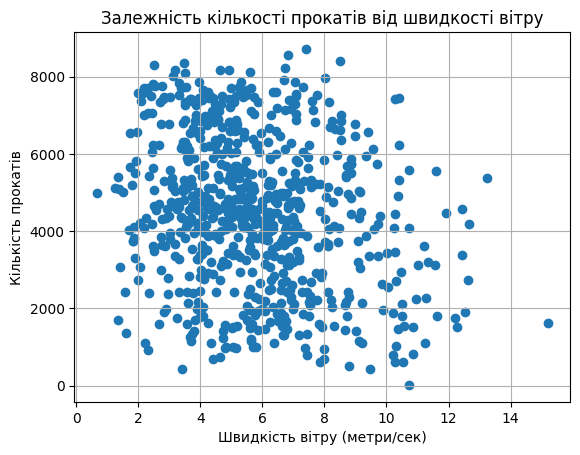

In [18]:
# График 12: windspeed(ms) vs cnt

plt.scatter(df['windspeed(ms)'], df['cnt'])

plt.xlabel('Швидкість вітру (метри/сек)')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від швидкості вітру')
plt.grid()
plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

**Відповідь:**
1. У літні місяці (з червня до серпня) кількість прокатів досягає свого піку.
Взимку (грудень-лютий) кількість прокатів знижується
Навесні (березень-травень) та восени (вересень-листопад) спостерігається середня кількість прокатів
2. Температура (ознака "temp" та "atemp"): Зазвичай зі збільшенням температури підвищується попит на оренду велосипедів

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [19]:
correlations = df.corrwith(df['cnt'])
correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [20]:
correlations_df = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
correlations_df

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [21]:
feature_means = df.mean()
feature_means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [22]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [23]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [24]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [25]:
regressor = LinearRegression()

regressor.fit(X, y)

weights = list(zip(df.columns[:-1], regressor.coef_))
for feature, weight in weights:
    print(f"Ознака: {feature}, Вага: {weight}")

Ознака: season, Вага: 570.8637960129914
Ознака: yr, Вага: 1021.9653779400622
Ознака: mnth, Вага: -141.3017451148728
Ознака: holiday, Вага: -86.7593446245368
Ознака: weekday, Вага: 137.22506441350538
Ознака: workingday, Вага: 56.391881775973005
Ознака: weathersit, Вага: -330.2264620440312
Ознака: temp, Вага: 367.48373260182126
Ознака: atemp, Вага: 585.5493861188597
Ознака: hum, Вага: -145.61430569885857
Ознака: windspeed(mph), Вага: 12457138390688.885
Ознака: windspeed(ms), Вага: -12457138390887.346


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [26]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X, y)

feature_weights = list(zip(df.columns, lasso.coef_))
for feature, weight in feature_weights:
    print(f"Ознака: {feature}, Вага: {weight}")

Ознака: season, Вага: 560.2416160308861
Ознака: yr, Вага: 1019.4634940657196
Ознака: mnth, Вага: -128.73062703678696
Ознака: holiday, Вага: -86.15278133371106
Ознака: weekday, Вага: 137.34789390496314
Ознака: workingday, Вага: 55.21237064135668
Ознака: weathersit, Вага: -332.3698569623487
Ознака: temp, Вага: 376.3632362096943
Ознака: atemp, Вага: 576.530793504555
Ознака: hum, Вага: -144.12915500348583
Ознака: windspeed(mph), Вага: -197.1396894024843
Ознака: windspeed(ms), Вага: -2.8051404183533485e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [27]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X, y)

feature_weights = list(zip(df.columns, ridge.coef_))
for feature, weight in feature_weights:
    print(f"Ознака: {feature}, Вага: {weight}")

Ознака: season, Вага: 563.0645722520181
Ознака: yr, Вага: 1018.9483787875305
Ознака: mnth, Вага: -131.87332028247715
Ознака: holiday, Вага: -86.74609799709232
Ознака: weekday, Вага: 138.00511117871918
Ознака: workingday, Вага: 55.90311037506467
Ознака: weathersit, Вага: -332.34978849907367
Ознака: temp, Вага: 386.45788919190807
Ознака: atemp, Вага: 566.3470470600669
Ознака: hum, Вага: -145.07132729867195
Ознака: windspeed(mph), Вага: -99.25944108179067
Ознака: windspeed(ms), Вага: -99.25944115434177


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [28]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

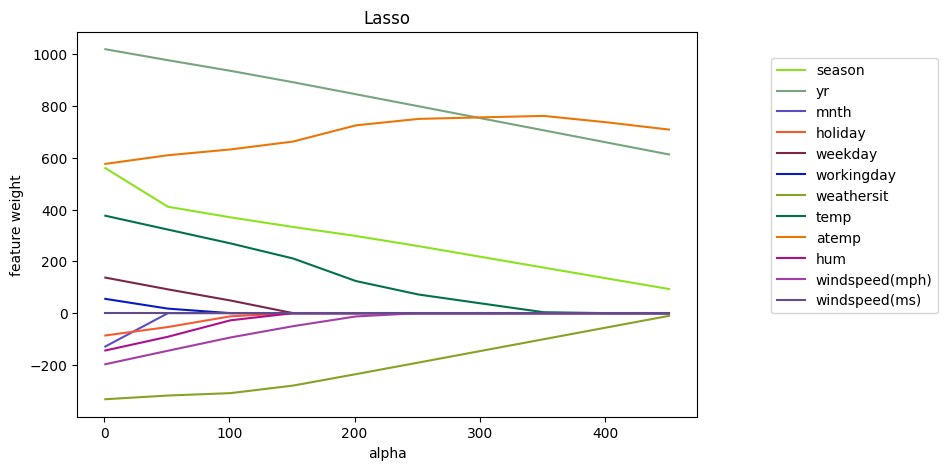

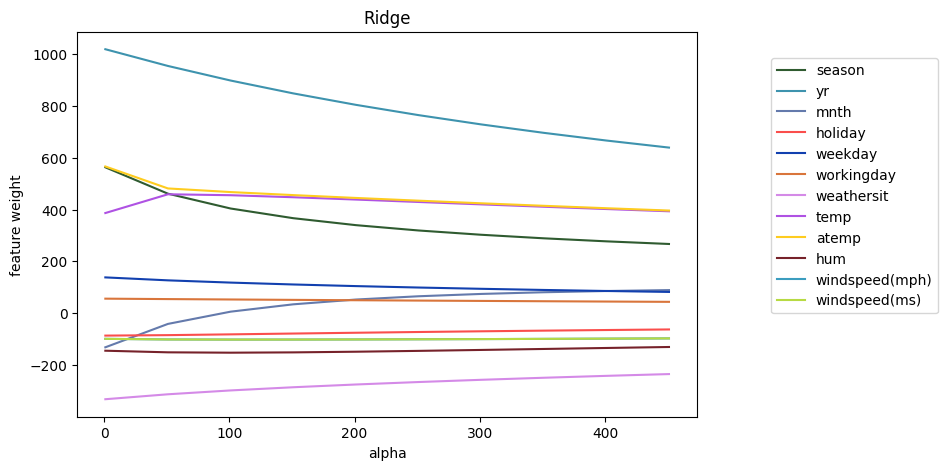

In [29]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

**Відповідь:**
1. Виходячи з результатів, можна дійти невтішного висновку, що Lasso-регуляризация при одному й тому значенні alpha агресивніше зменшує ваги проти Ridge-регуляризацией. Lasso обнулює деякі ознаки, тоді як Ridge лише зменшує їх значення, але не виключає повністю.

2. Якщо значення alpha в Lasso-регуляризації встановити дуже великим, то всі ваги ознак будуть прагнути до нуля або повністю обнулятися.

Це відбувається через особливості L1-регуляризації, яка включає суму абсолютних значень ваг у функціонал помилки моделі. При збільшенні значення alpha ця сума стає більш значущою в оптимізаційній задачі, що призводить до зменшення значень ваг.

Однією із важливих особливостей L1-регуляризації є її здатність до розріджування (sparsity). Оскільки вона стимулює обнулення деяких ваг, Lasso може відбирати найінформативніші ознаки та ігнорувати менш значущі. При дуже великому значенні alpha всі ознаки стають менш значущими, і модель відкидає їх мінімізувати функціонал помилки.

Таким чином, збільшення alpha в Lasso-регуляризації посилює ефект розріджування, призводячи до обнулення ваг ознак та вибору найбільш інформативних ознак для побудови моделі.

3. Так, можна стверджувати, що Lasso виключає одну з ознак windspeed за будь-якого значення alpha > 0.

Lasso-регуляризація має властивість сильного розріджування, тобто вона схильна обнулювати ваги ознак. Якщо ознака windspeed несуттєва для передбачення цільової змінної, то Lasso при будь-якому значенні alpha > 0 обнулює його вагу, і ця ознака буде виключена з моделі. Це відбувається через використання L1-норми в регуляризаційному члені, яка стимулює розрідження ваги.

З іншого боку, Ridge-регуляризація не обнуляє ваги ознак повністю за будь-якого значення alpha > 0. Ridge використовує L2-норму в регуляризационном члені, яка штрафує великі значення ваг, але не обнуляє їх повністю. Таким чином, ознака windspeed може бути значущою або менш значущою в моделі Ridge, але вона не буде повністю виключена з моделі.

Отже, у випадку Lasso можна стверджувати, що при досить великому alpha вага ознаки windspeed буде обнулена, а у випадку Ridge вага цієї ознаки може бути зменшена, але не повністю обнулена.

4. Для відбору неінформативних ознак зазвичай рекомендується використовувати Lasso-регуляризацію. Lasso має властивість сильного розріджування, що означає, що він схильний обнулювати ваги неінформативних ознак, роблячи їхній внесок у модель незначним або виключаючи їх повністю.

При використанні L1-норми в регуляризаційному члені Lasso стимулює розрідження ваг, що дозволяє виключати неінформативні ознаки з моделі. Це особливо корисно, коли є велика кількість ознак, серед яких багато хто не робить значний внесок у передбачення цільової змінної.

На відміну від цього, Ridge-регуляризація з використанням L2-норми штрафує великі значення ваги, але не обнуляє їх повністю. Це може призвести до того, що навіть неінформативні ознаки матимуть ненульові ваги, але з меншою значимістю, порівняно з інформативними ознаками.

Таким чином, якщо вам потрібен відбір неінформативних ознак, Lasso-регуляризація буде кращим вибором, оскільки вона має властивість розріджування і може ефективно виключати неінформативні ознаки з моделі.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [30]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [31]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas)
regressor.fit(X, y)

LassoCV(alphas=array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]))

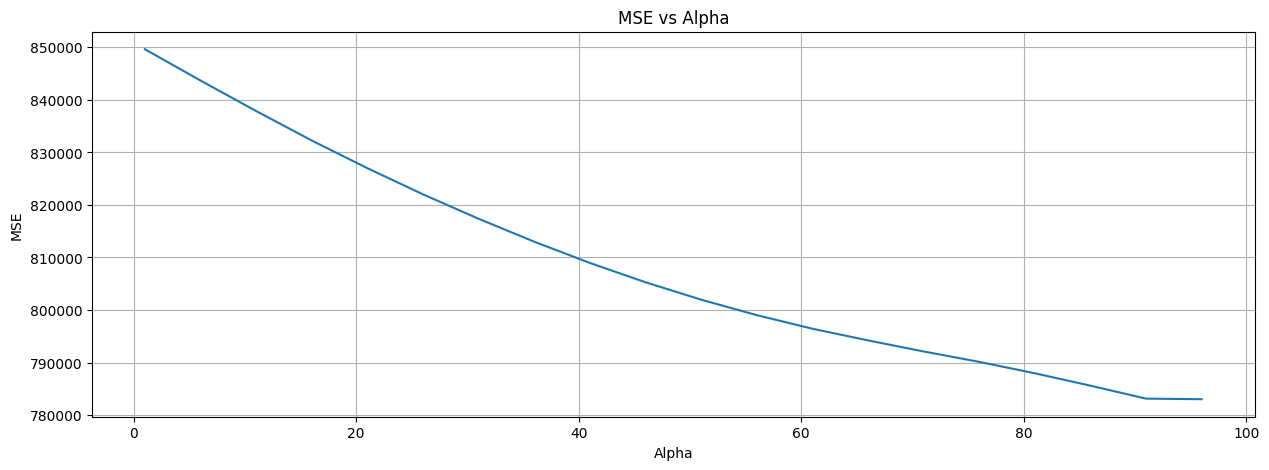

In [32]:
mse_values = np.mean(regressor.mse_path_, axis=1)
data = list(zip(alphas, mse_values))

create_plot(data, 'MSE vs Alpha', 'Alpha', 'MSE')


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


In [45]:
min_alpha_values = []
for mse, alpha in zip(regressor.mse_path_.mean(axis=0), regressor.alphas_):
    min_alpha_values.append((alpha, mse))

print("Alphas with minimum MSE:")
for alpha, mse in min_alpha_values:
    print(f"Alpha = {alpha}, MSE = {mse:.2f}")

Alphas with minimum MSE:
Alpha = 96, MSE = 740515.62
Alpha = 91, MSE = 891375.55
Alpha = 86, MSE = 780504.39
Alpha = 81, MSE = 870456.41
Alpha = 76, MSE = 759817.95


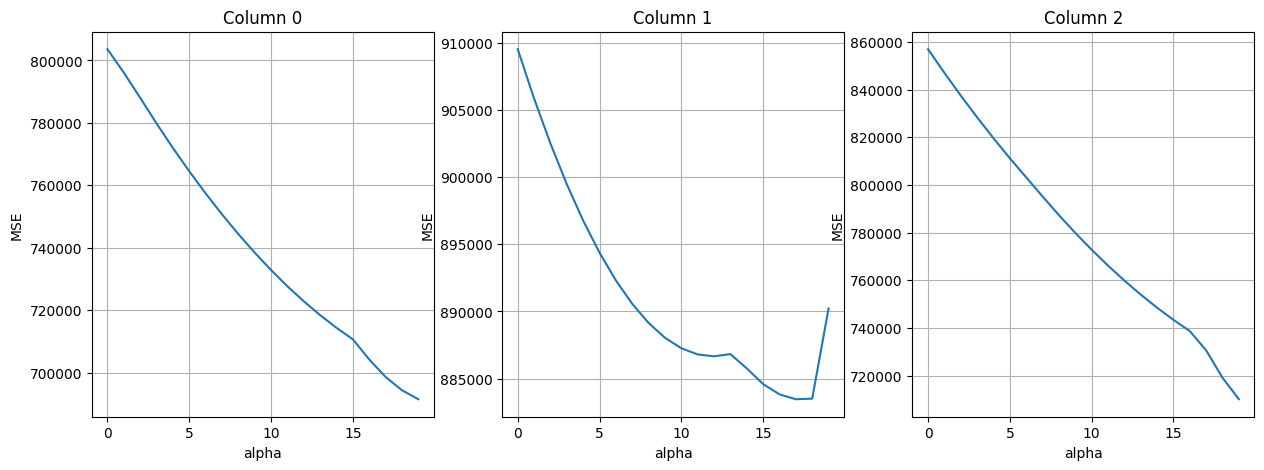

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    axs[i].plot(regressor.mse_path_[:,i])
    axs[i].set_title(f'Column {i}')
    axs[i].set_xlabel('alpha')
    axs[i].set_ylabel('MSE')
    axs[i].grid()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__
В результаті останньої навченої моделі Lasso ви отримали такі ознаки з найбільшими позитивними коефіцієнтами:

Ознака: season, Вага: 560.2416160308861

Ознака: yr, Вага: 1019.4634940657196

Ознака: temp, Вага: 376.3632362096943

Ознака: atemp, Вага: 576.530793504555

між якими існує позитивна лінійна залежність між цими ознаками та cnt.

Зі здорового глузду можна припустити такі логічні зв'язки між ознаками та кількістю орендованих велосипедів:

Season (Сезон): Логічно припустити, що в теплі сезони (літо та весна) кількість орендованих велосипедів може бути вищою, оскільки в цей час більш комфортно та приємно кататися на велосипеді. Взимку та восени попит на велосипеди може бути нижчим через холоднішу і нестабільнішу погоду.

Year (Рік): Можна припустити, що з часом попит на оренду велосипедів може зростати, оскільки велосипеди стають все більш популярним та зручним засобом пересування. Таким чином, кількість орендованих велосипедів може бути вищою в пізніші роки.

Temperature (Температура) та Feels-like Temperature (Температура за відчуттями): Високі температури та комфортніші відчуття температури можуть стимулювати людей до активного використання велосипедів. У теплу погоду люди частіше віддають перевагу активним формам відпочинку та пересування, включаючи прокат велосипедів.

Однак, слід зазначити, що ці припущення засновані на загальних спостереженнях та здоровому глузді, і для отримання точних висновків та прогнозів потрібен глибший аналіз даних

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# График 1: season vs cnt
season_rentals = df.groupby('season')['cnt'].mean()
season_labels = ['Весна', 'Літо', 'Осінь', 'Зима']

axes[0, 0].plot(season_labels, season_rentals, marker='o')
axes[0, 0].set_xlabel('Сезон')
axes[0, 0].set_ylabel('Кількість прокатів')
axes[0, 0].set_title('Залежність кількості прокатів від сезону')

# График 2: yr vs cnt
year_rentals = df.groupby('yr')['cnt'].mean()
year_labels = ['2011', '2012']

axes[0, 1].bar(year_labels, year_rentals)
axes[0, 1].set_xlabel('Рік')
axes[0, 1].set_ylabel('Кількість прокатів')
axes[0, 1].set_title('Залежність кількості прокатів від року')

# График 3: temp vs cnt
axes[1, 0].scatter(df['temp'], df['cnt'])
axes[1, 0].set_xlabel('Температура')
axes[1, 0].set_ylabel('Кількість прокатів')
axes[1, 0].set_title('Залежність кількості прокатів від температури')

# График 4: atemp vs cnt
axes[1, 1].scatter(df['atemp'], df['cnt'])
axes[1, 1].set_xlabel('Температура за відчуттями')
axes[1, 1].set_ylabel('Кількість прокатів')
axes[1, 1].set_title('Залежність кількості прокатів від температури')

plt.tight_layout()
plt.show()

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__
На основі отриманих ваг признаків, три признаки з найбільшими за модулем від'ємними коефіцієнтами будуть:

weathersit: -332.3698569623487

windspeed(mph): -197.1396894024843

hum: -144.12915500348583

Для ознак з найбільшими від'ємними коефіцієнтами видно спадну лінійну залежність. Це означає, що зі збільшенням значень цих ознак кількість прокатів велосипедів зменшується.

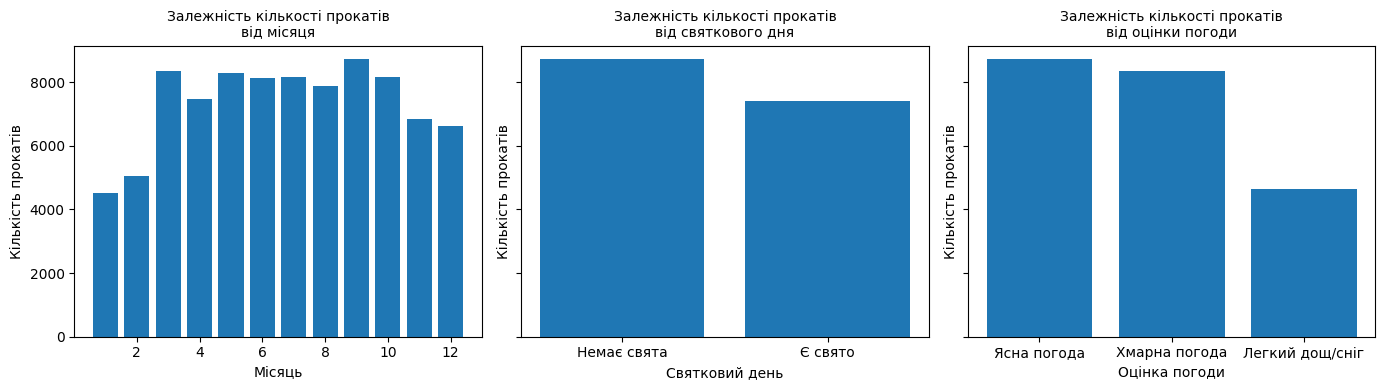

In [91]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))

axs[0].bar(df['mnth'], df['cnt'])
axs[0].set_xlabel('Місяць')
axs[0].set_ylabel('Кількість прокатів')
axs[0].set_title('Залежність кількості прокатів\nвід місяця', fontsize=10)

axs[1].bar(df['holiday'], df['cnt'])
axs[1].set_xlabel('Святковий день')
axs[1].set_ylabel('Кількість прокатів')
axs[1].set_title('Залежність кількості прокатів\nвід святкового дня', fontsize=10)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Немає свята', 'Є свято'])

axs[2].bar(df['weathersit'], df['cnt'])
axs[2].set_xlabel('Оцінка погоди')
axs[2].set_ylabel('Кількість прокатів')
axs[2].set_title('Залежність кількості прокатів\nвід оцінки погоди', fontsize=10)
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(['Ясна погода', 'Хмарна погода', 'Легкий дощ/сніг'])

plt.tight_layout()
plt.show()


#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__
На підставі отриманих ваг одна ознака з коефіцієнтом близьким до нуля:

windspeed(ms): -2.8051404183533485e-08

Модель виключає ознаки з коефіцієнтами, близькими до нуля тому, що вони мають дуже маленьку важливість для передбачення цільової ознаки. Це може вказувати на те, що ці ознаки слабко впливають на кількість орендованих велосипедів або можуть бути лінійно залежними з іншими ознаками. У разі модель може виключити ці ознаки, щоб спростити модель і уникнути зайвої складності. Однак, це не означає, що вони не впливають на попит на велосипеди в реальності.

Важливо відзначити, що вплив ознак на попит на велосипеди може бути складним та залежить від багатьох факторів. Модель може не вловлювати деякі нетривіальні залежності чи взаємодії між ознаками. Також модель може визначити, що інші ознаки роблять більш значний внесок у пояснення варіації попиту на велосипеди, тому коефіцієнти цих ознак виявляються значнішими.

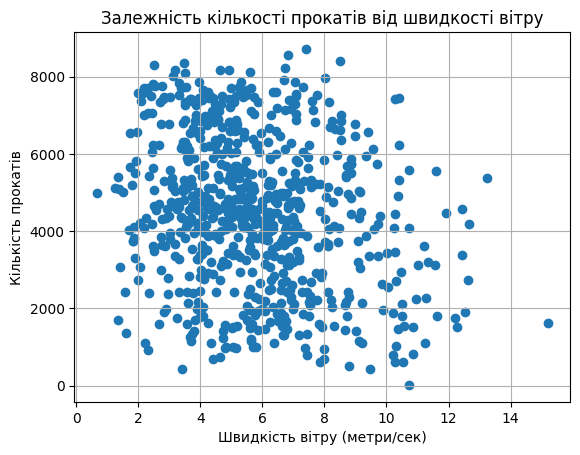

In [95]:
# График 12: windspeed(ms) vs cnt

plt.scatter(df['windspeed(ms)'], df['cnt'])

plt.xlabel('Швидкість вітру (метри/сек)')
plt.ylabel('Кількість прокатів')
plt.title('Залежність кількості прокатів від швидкості вітру')
plt.grid()
plt.show()

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.